In [2]:
!pip install networkx pulp gurobipy ortools matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


## 1

Chromatic number: 3
Coloring: {0: 0, 1: 1, 2: 2, 3: 1, 4: 2, 5: 1, 6: 0, 7: 0, 8: 2, 9: 1}


<ipython-input-6-bc286e993da6>:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


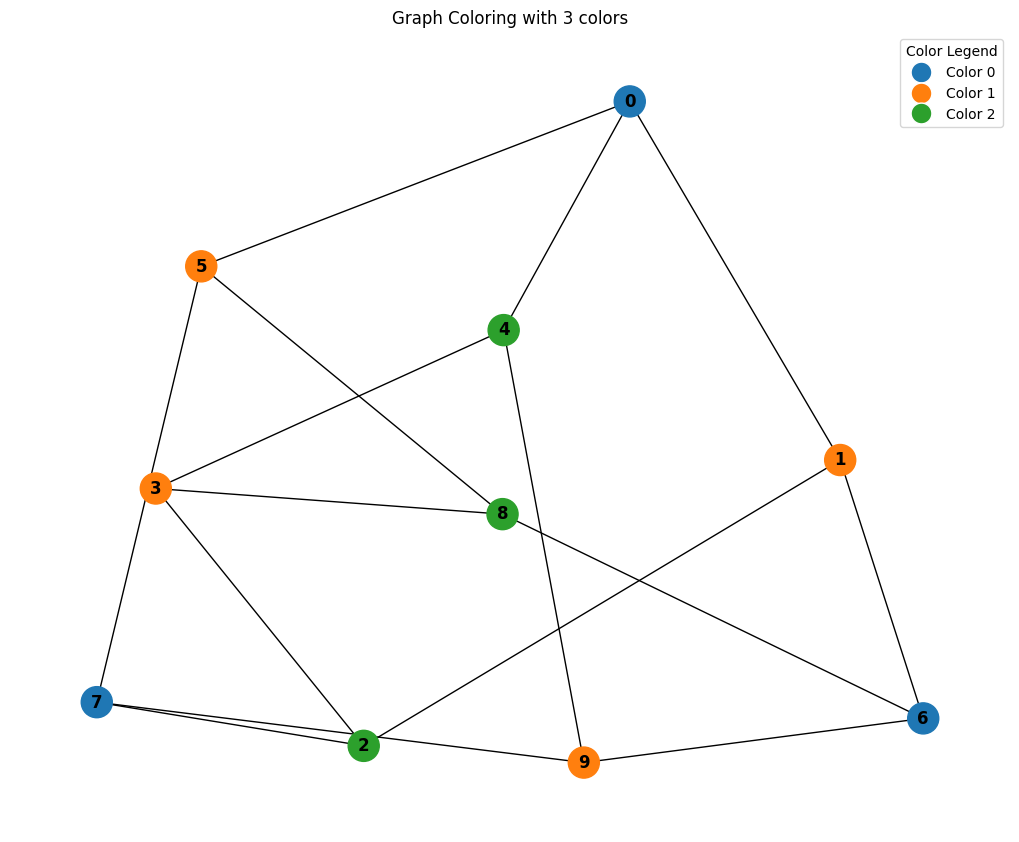

In [ ]:
import networkx as nx
import pulp
import matplotlib.pyplot as plt
import random

def graph_coloring_pulp(G, max_colors=None):
    """
    Solve the graph coloring problem using PuLP.

    Parameters:
    G (networkx.Graph): The input graph to be colored
    max_colors (int, optional): Maximum number of colors to use.
                               If None, will use number of nodes as upper bound.

    Returns:
    dict: A dictionary mapping nodes to colors (0-indexed)
    int: The number of colors used
    """
    # If max_colors is not specified, use the number of nodes as an upper bound
    if max_colors is None:
        max_colors = len(G.nodes())

    # Create the optimization model
    model = pulp.LpProblem("GraphColoring", pulp.LpMinimize)

    # Create variables
    # x[i, c] = 1 if node i is assigned color c, 0 otherwise
    x = pulp.LpVariable.dicts("x",
                              [(i, c) for i in G.nodes() for c in range(max_colors)],
                              cat=pulp.LpBinary)

    # y[c] = 1 if color c is used, 0 otherwise
    y = pulp.LpVariable.dicts("y",
                              [c for c in range(max_colors)],
                              cat=pulp.LpBinary)

    # Objective: Minimize the number of colors used
    model += pulp.lpSum(y[c] for c in range(max_colors))

    # Constraint: Each node must be assigned exactly one color
    for i in G.nodes():
        model += pulp.lpSum(x[i, c] for c in range(max_colors)) == 1

    # Constraint: Adjacent nodes must have different colors
    for (i, j) in G.edges():
        for c in range(max_colors):
            model += x[i, c] + x[j, c] <= 1

    # Constraint: If a color is assigned to any node, mark it as used
    for c in range(max_colors):
        for i in G.nodes():
            model += x[i, c] <= y[c]

    # Constraint: Use colors in order (symmetry breaking)
    for c in range(1, max_colors):
        model += y[c] <= y[c-1]

    # Solve the model
    model.solve(pulp.PULP_CBC_CMD(msg=False))

    # Extract the solution
    coloring = {}
    for i in G.nodes():
        for c in range(max_colors):
            if pulp.value(x[i, c]) == 1:
                coloring[i] = c
                break

    # Count colors used
    colors_used = sum(1 for c in range(max_colors) if pulp.value(y[c]) == 1)

    return coloring, colors_used

def visualize_coloring(G, coloring):
    """Visualize the graph with its coloring"""
    # Define a set of distinct colors for visualization
    color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # If we need more colors, generate them randomly
    if max(coloring.values()) >= len(color_map):
        for _ in range(max(coloring.values()) - len(color_map) + 1):
            color_map.append('#%06X' % random.randint(0, 0xFFFFFF))

    # Assign colors to nodes
    node_colors = [color_map[coloring[node]] for node in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')

    # Add a color legend
    used_colors = set(coloring.values())
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c],
                                  markersize=15, label=f'Color {c}') for c in used_colors]
    plt.legend(handles=legend_elements, title="Color Legend")

    plt.title(f"Graph Coloring with {len(used_colors)} colors")
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Create a sample graph (Petersen graph)
    G = nx.petersen_graph()

    # Solve the coloring problem
    coloring, colors_used = graph_coloring_pulp(G)

    print(f"Chromatic number: {colors_used}")
    print(f"Coloring: {coloring}")

    # Visualize the result
    visualize_coloring(G, coloring)

Restricted license - for non-production use only - expires 2026-11-23
Chromatic number: 3
Coloring: {0: 0, 1: 1, 2: 0, 3: 1, 4: 2, 5: 1, 6: 0, 7: 2, 8: 2, 9: 1}


<ipython-input-7-852d13f501e6>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


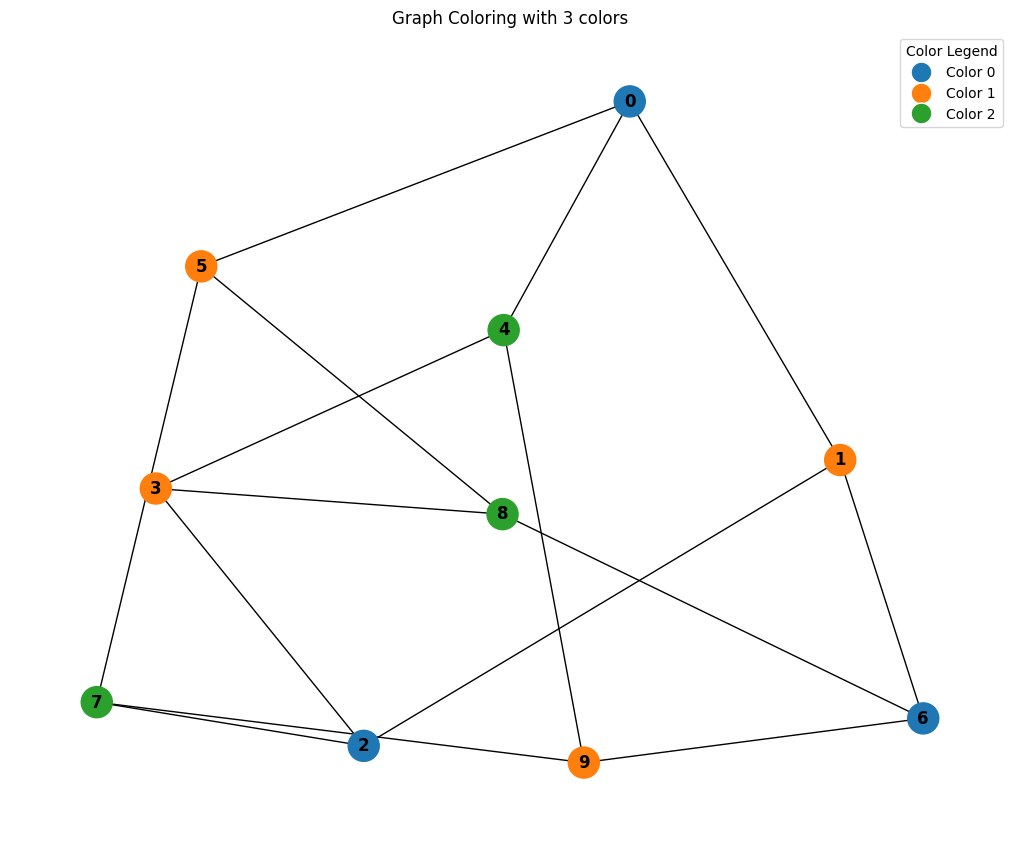

In [ ]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import random

def graph_coloring_gurobi(G, max_colors=None):
    """
    Solve the graph coloring problem using Gurobi.

    Parameters:
    G (networkx.Graph): The input graph to be colored
    max_colors (int, optional): Maximum number of colors to use.
                               If None, will use number of nodes as upper bound.

    Returns:
    dict: A dictionary mapping nodes to colors (0-indexed)
    int: The number of colors used
    """
    # If max_colors is not specified, use the number of nodes as an upper bound
    if max_colors is None:
        max_colors = len(G.nodes())

    # Create a new model
    model = gp.Model("GraphColoring")

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)

    # Create variables
    # x[i, c] = 1 if node i is assigned color c, 0 otherwise
    x = {}
    for i in G.nodes():
        for c in range(max_colors):
            x[i, c] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{c}")

    # y[c] = 1 if color c is used, 0 otherwise
    y = {}
    for c in range(max_colors):
        y[c] = model.addVar(vtype=GRB.BINARY, name=f"y_{c}")

    # Objective: Minimize the number of colors used
    model.setObjective(gp.quicksum(y[c] for c in range(max_colors)), GRB.MINIMIZE)

    # Constraint: Each node must be assigned exactly one color
    for i in G.nodes():
        model.addConstr(gp.quicksum(x[i, c] for c in range(max_colors)) == 1, f"node_{i}_one_color")

    # Constraint: Adjacent nodes must have different colors
    for (i, j) in G.edges():
        for c in range(max_colors):
            model.addConstr(x[i, c] + x[j, c] <= 1, f"edge_{i}_{j}_color_{c}")

    # Constraint: If a color is assigned to any node, mark it as used
    for c in range(max_colors):
        for i in G.nodes():
            model.addConstr(x[i, c] <= y[c], f"color_{c}_used_by_{i}")

    # Constraint: Use colors in order (symmetry breaking)
    for c in range(1, max_colors):
        model.addConstr(y[c] <= y[c-1], f"color_order_{c}")

    # Optimize model
    model.optimize()

    # Check if a solution was found
    if model.status == GRB.OPTIMAL:
        # Extract the solution
        coloring = {}
        for i in G.nodes():
            for c in range(max_colors):
                if x[i, c].X > 0.5:  # Value is close to 1
                    coloring[i] = c
                    break

        # Count colors used
        colors_used = sum(1 for c in range(max_colors) if y[c].X > 0.5)

        return coloring, colors_used
    else:
        return None, 0

def visualize_coloring(G, coloring):
    """Visualize the graph with its coloring"""
    # Define a set of distinct colors for visualization
    color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # If we need more colors, generate them randomly
    if max(coloring.values()) >= len(color_map):
        for _ in range(max(coloring.values()) - len(color_map) + 1):
            color_map.append('#%06X' % random.randint(0, 0xFFFFFF))

    # Assign colors to nodes
    node_colors = [color_map[coloring[node]] for node in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')

    # Add a color legend
    used_colors = set(coloring.values())
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c],
                                  markersize=15, label=f'Color {c}') for c in used_colors]
    plt.legend(handles=legend_elements, title="Color Legend")

    plt.title(f"Graph Coloring with {len(used_colors)} colors")
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Create a sample graph (Petersen graph)
    G = nx.petersen_graph()

    # Solve the coloring problem
    coloring, colors_used = graph_coloring_gurobi(G)

    if coloring:
        print(f"Chromatic number: {colors_used}")
        print(f"Coloring: {coloring}")

        # Visualize the result
        visualize_coloring(G, coloring)
    else:
        print("No solution found.")

Chromatic number: 3
Coloring: {0: 0, 1: 2, 2: 0, 3: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 0, 9: 0}


<ipython-input-9-a09e3b8a955d>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


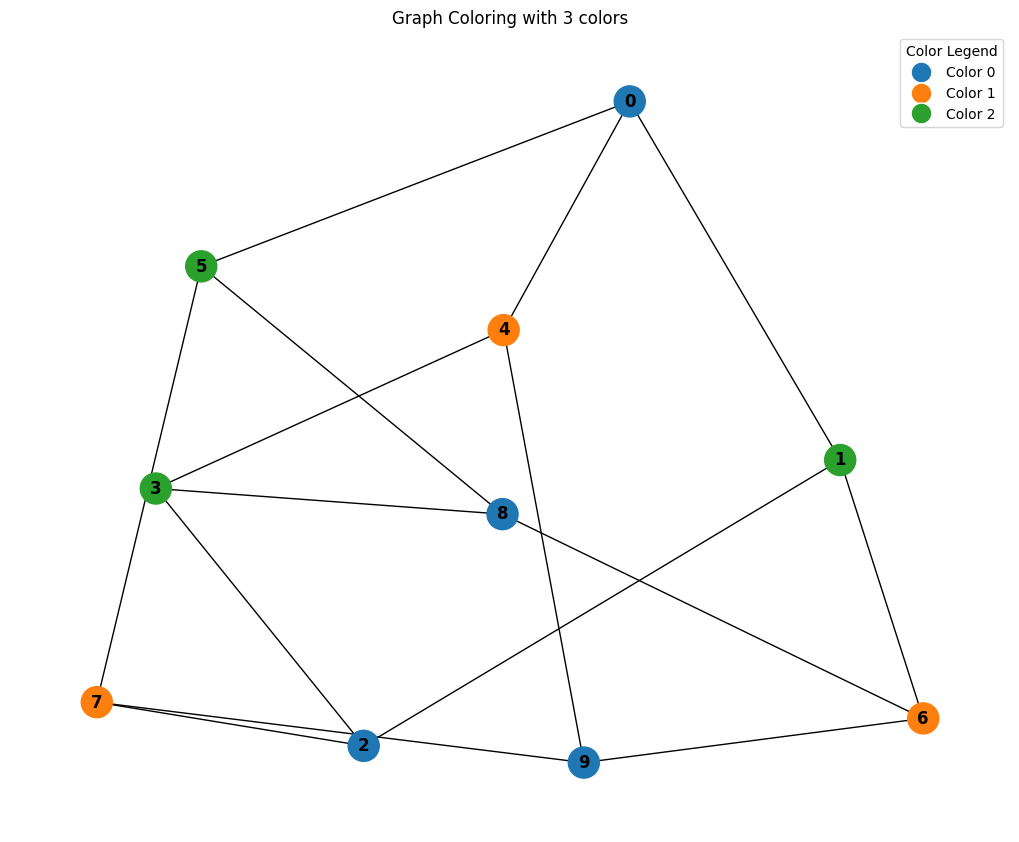

In [ ]:
import networkx as nx
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import random

def graph_coloring_ortools(G, max_colors=None):
    """
    Solve the graph coloring problem using Google OR-Tools CP-SAT solver.

    Parameters:
    G (networkx.Graph): The input graph to be colored
    max_colors (int, optional): Maximum number of colors to use.
                               If None, will use number of nodes as upper bound.

    Returns:
    dict: A dictionary mapping nodes to colors (0-indexed)
    int: The number of colors used
    """
    # If max_colors is not specified, use the number of nodes as an upper bound
    if max_colors is None:
        max_colors = len(G.nodes())

    # Create a new CP-SAT model
    model = cp_model.CpModel()

    # Create variables for node colors
    # color[i] = color assigned to node i (0 to max_colors-1)
    color = {}
    for i in G.nodes():
        color[i] = model.NewIntVar(0, max_colors - 1, f'color_{i}')

    # Create variables to track which colors are used
    # used[c] = 1 if color c is used, 0 otherwise
    used = {}
    for c in range(max_colors):
        used[c] = model.NewBoolVar(f'used_{c}')

    # Constraint: Adjacent nodes must have different colors
    for (i, j) in G.edges():
        model.Add(color[i] != color[j])

    # Constraint: Mark colors as used
    for i in G.nodes():
        for c in range(max_colors):
            # Create a boolean variable that is true if node i has color c
            is_color_c = model.NewBoolVar(f'node_{i}_color_{c}')
            model.Add(color[i] == c).OnlyEnforceIf(is_color_c)
            model.Add(color[i] != c).OnlyEnforceIf(is_color_c.Not())

            # If any node has color c, then used[c] must be 1
            model.AddImplication(is_color_c, used[c])

    # Additional constraint to enforce used[c] = 0 if no node uses color c
    for c in range(max_colors):
        # Create a list of boolean variables indicating if any node uses color c
        color_usage = []
        for i in G.nodes():
            uses_color = model.NewBoolVar(f'node_{i}_uses_{c}')
            model.Add(color[i] == c).OnlyEnforceIf(uses_color)
            model.Add(color[i] != c).OnlyEnforceIf(uses_color.Not())
            color_usage.append(uses_color)

        # If no node uses color c, then used[c] must be 0
        model.AddBoolOr(color_usage).OnlyEnforceIf(used[c])
        model.AddBoolAnd([v.Not() for v in color_usage]).OnlyEnforceIf(used[c].Not())

    # Constraint: Use colors in order (symmetry breaking)
    for c in range(1, max_colors):
        model.Add(used[c-1] >= used[c])

    # Objective: Minimize the number of colors used
    model.Minimize(sum(used[c] for c in range(max_colors)))

    # Create solver and solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # Extract the solution if one was found
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        coloring = {i: solver.Value(color[i]) for i in G.nodes()}
        colors_used = sum(solver.Value(used[c]) for c in range(max_colors))
        return coloring, colors_used
    else:
        return None, 0

def visualize_coloring(G, coloring):
    """Visualize the graph with its coloring"""
    # Define a set of distinct colors for visualization
    color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # If we need more colors, generate them randomly
    if max(coloring.values()) >= len(color_map):
        for _ in range(max(coloring.values()) - len(color_map) + 1):
            color_map.append('#%06X' % random.randint(0, 0xFFFFFF))

    # Assign colors to nodes
    node_colors = [color_map[coloring[node]] for node in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')

    # Add a color legend
    used_colors = set(coloring.values())
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c],
                                  markersize=15, label=f'Color {c}') for c in used_colors]
    plt.legend(handles=legend_elements, title="Color Legend")

    plt.title(f"Graph Coloring with {len(used_colors)} colors")
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Create a sample graph (Petersen graph)
    G = nx.petersen_graph()

    # Solve the coloring problem
    coloring, colors_used = graph_coloring_ortools(G)

    if coloring:
        print(f"Chromatic number: {colors_used}")
        print(f"Coloring: {coloring}")

        # Visualize the result
        visualize_coloring(G, coloring)
    else:
        print("No solution found.")

## 2

In [ ]:
from ortools.sat.python import cp_model

def graph_coloring_or_tools(adjacency_matrix, max_colors):
    """
    Solve the graph coloring problem using Google OR-Tools CP-SAT solver.

    Parameters:
    - adjacency_matrix: 2D list representing graph edges
    - max_colors: Maximum number of colors to use

    Returns:
    - colors: List of colors assigned to each vertex
    - num_colors: Number of colors used
    """
    n = len(adjacency_matrix)  # Number of vertices

    # Create the model
    model = cp_model.CpModel()

    # Variables: color[i] is the color of vertex i (0 to max_colors-1)
    color = [model.NewIntVar(0, max_colors - 1, f'color_{i}') for i in range(n)]

    # Objective: minimize the maximum color used
    max_color_used = model.NewIntVar(0, max_colors - 1, 'max_color_used')
    model.AddMaxEquality(max_color_used, color)
    model.Minimize(max_color_used)

    # Constraints: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                model.Add(color[i] != color[j])

    # Symmetry breaking: color of first vertex = 0
    model.Add(color[0] == 0)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extract solution
        vertex_colors = [solver.Value(color[i]) for i in range(n)]
        num_colors_used = max(vertex_colors) + 1
        return vertex_colors, num_colors_used
    else:
        return None, None

# Example with 5 vertices
if __name__ == "__main__":
    # Example graph with 5 vertices
    # Adjacency matrix where 1 indicates an edge between vertices
    adjacency_matrix = [
        [0, 1, 1, 1, 0],  # Vertex 0 connected to 1, 2, 3
        [1, 0, 1, 0, 1],  # Vertex 1 connected to 0, 2, 4
        [1, 1, 0, 1, 0],  # Vertex 2 connected to 0, 1, 3
        [1, 0, 1, 0, 1],  # Vertex 3 connected to 0, 2, 4
        [0, 1, 0, 1, 0]   # Vertex 4 connected to 1, 3
    ]

    max_possible_colors = 5  # Maximum number of colors we might need

    # Solve the problem
    colors, num_colors = graph_coloring_or_tools(adjacency_matrix, max_possible_colors)

    if colors:
        print(f"Solution found using {num_colors} colors:")
        for i, color in enumerate(colors):
            print(f"Vertex {i}: Color {color}")
    else:
        print("No solution found")

Solution found using 3 colors:
Vertex 0: Color 0
Vertex 1: Color 2
Vertex 2: Color 1
Vertex 3: Color 2
Vertex 4: Color 0


## With Visulatization

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from ortools.sat.python import cp_model
import gurobipy as gp
from gurobipy import GRB
import pulp

def graph_coloring_pulp(adjacency_matrix, max_colors):
    """
    Solve the graph coloring problem using PuLP.

    Parameters:
    - adjacency_matrix: 2D list representing graph edges
    - max_colors: Maximum number of colors to use

    Returns:
    - colors: List of colors assigned to each vertex
    - num_colors: Number of colors used
    """
    n = len(adjacency_matrix)  # Number of vertices

    # Create the model
    model = pulp.LpProblem("GraphColoring", pulp.LpMinimize)

    # Define the set of possible colors
    colors = range(max_colors)

    # Variables: x[i][j] = 1 if vertex i has color j, 0 otherwise
    x = {(i, j): pulp.LpVariable(f'x_{i}_{j}', cat=pulp.LpBinary)
         for i in range(n) for j in colors}

    # Variables: y[j] = 1 if color j is used, 0 otherwise
    y = {j: pulp.LpVariable(f'y_{j}', cat=pulp.LpBinary)
         for j in colors}

    # Objective: minimize the number of colors used
    model += pulp.lpSum(y[j] for j in colors)

    # Constraint: each vertex must have exactly one color
    for i in range(n):
        model += pulp.lpSum(x[i, j] for j in colors) == 1

    # Constraint: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                for c in colors:
                    model += x[i, c] + x[j, c] <= 1

    # Constraint: if color j is assigned to any vertex, then y[j] = 1
    for j in colors:
        for i in range(n):
            model += x[i, j] <= y[j]

    # Additional constraint: if color j is used, then color j-1 must be used (to avoid symmetry)
    for j in range(1, max_colors):
        model += y[j] <= y[j-1]

    # Solve the model
    model.solve(pulp.PULP_CBC_CMD(msg=False))

    if model.status == pulp.LpStatusOptimal:
        # Extract solution
        vertex_colors = [next(j for j in colors if pulp.value(x[i, j]) > 0.5) for i in range(n)]
        num_colors_used = sum(pulp.value(y[j]) > 0.5 for j in colors)
        return vertex_colors, int(num_colors_used)
    else:
        return None, None

def graph_coloring_or_tools(adjacency_matrix, max_colors):
    """
    Solve the graph coloring problem using Google OR-Tools CP-SAT solver.

    Parameters:
    - adjacency_matrix: 2D list representing graph edges
    - max_colors: Maximum number of colors to use

    Returns:
    - colors: List of colors assigned to each vertex
    - num_colors: Number of colors used
    """
    n = len(adjacency_matrix)  # Number of vertices

    # Create the model
    model = cp_model.CpModel()

    # Variables: color[i] is the color of vertex i (0 to max_colors-1)
    color = [model.NewIntVar(0, max_colors - 1, f'color_{i}') for i in range(n)]

    # Objective: minimize the maximum color used
    max_color_used = model.NewIntVar(0, max_colors - 1, 'max_color_used')
    model.AddMaxEquality(max_color_used, color)
    model.Minimize(max_color_used)

    # Constraints: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                model.Add(color[i] != color[j])

    # Symmetry breaking: color of first vertex = 0
    model.Add(color[0] == 0)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extract solution
        vertex_colors = [solver.Value(color[i]) for i in range(n)]
        num_colors_used = max(vertex_colors) + 1
        return vertex_colors, num_colors_used
    else:
        return None, None

def graph_coloring_gurobi(adjacency_matrix, max_colors):
    """
    Solve the graph coloring problem using Gurobi.

    Parameters:
    - adjacency_matrix: 2D list representing graph edges
    - max_colors: Maximum number of colors to use

    Returns:
    - colors: List of colors assigned to each vertex
    - num_colors: Number of colors used
    """
    n = len(adjacency_matrix)  # Number of vertices

    # Create a new model
    model = gp.Model("GraphColoring")

    # Suppress output
    model.setParam('OutputFlag', 0)

    # Define the set of possible colors
    colors = range(max_colors)

    # Variables: x[i,j] = 1 if vertex i has color j
    x = model.addVars([(i, j) for i in range(n) for j in colors], vtype=GRB.BINARY, name="x")

    # Variables: y[j] = 1 if color j is used
    y = model.addVars(colors, vtype=GRB.BINARY, name="y")

    # Objective: minimize the number of colors used
    model.setObjective(gp.quicksum(y[j] for j in colors), GRB.MINIMIZE)

    # Constraint: each vertex must have exactly one color
    for i in range(n):
        model.addConstr(gp.quicksum(x[i, j] for j in colors) == 1, f"OneColor_{i}")

    # Constraint: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                for c in colors:
                    model.addConstr(x[i, c] + x[j, c] <= 1, f"NoSameColor_{i}_{j}_{c}")

    # Constraint: if color j is assigned to any vertex, then y[j] = 1
    for j in colors:
        for i in range(n):
            model.addConstr(x[i, j] <= y[j], f"ColorUsed_{i}_{j}")

    # Additional constraint to break symmetry: if color j is used, then color j-1 must be used
    for j in range(1, max_colors):
        model.addConstr(y[j] <= y[j-1], f"Symmetry_{j}")

    # Solve the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Extract solution
        vertex_colors = [next(j for j in colors if x[i, j].X > 0.5) for i in range(n)]
        num_colors_used = sum(y[j].X > 0.5 for j in colors)
        return vertex_colors, int(num_colors_used)
    else:
        return None, None


def visualize_graph_coloring(adjacency_matrix, colors):
    """
    Visualize a graph with colored vertices.

    Parameters:
    - adjacency_matrix: 2D list representing graph edges
    - colors: List of colors assigned to each vertex
    """
    # Create graph from adjacency matrix
    G = nx.Graph()
    n = len(adjacency_matrix)

    # Add nodes
    for i in range(n):
        G.add_node(i)

    # Add edges
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)

    # Define color map
    color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # If we have more colors than in our map, cycle through them
    node_colors = [color_map[c % len(color_map)] for c in colors]

    # Create a nice layout
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 8))

    # Draw the graph with colored nodes
    nx.draw(G, pos,
            node_color=node_colors,
            node_size=700,
            with_labels=True,
            font_size=16,
            font_weight='bold',
            font_color='white',
            edge_color='gray',
            linewidths=1,
            alpha=0.9)

    # Create a legend for the colors
    color_labels = {i: f"Color {i}" for i in set(colors)}
    patches = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=color_map[c % len(color_map)],
                          markersize=15, label=color_labels[c])
               for c in sorted(set(colors))]

    plt.legend(handles=patches, title="Color Assignment", loc='upper right')
    plt.title('Graph Coloring Visualization (5 Vertices)', fontsize=16)

    plt.tight_layout()
    return plt



Solving the graph coloring problem with Gurobi...


<ipython-input-8-656b7656ae73>:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


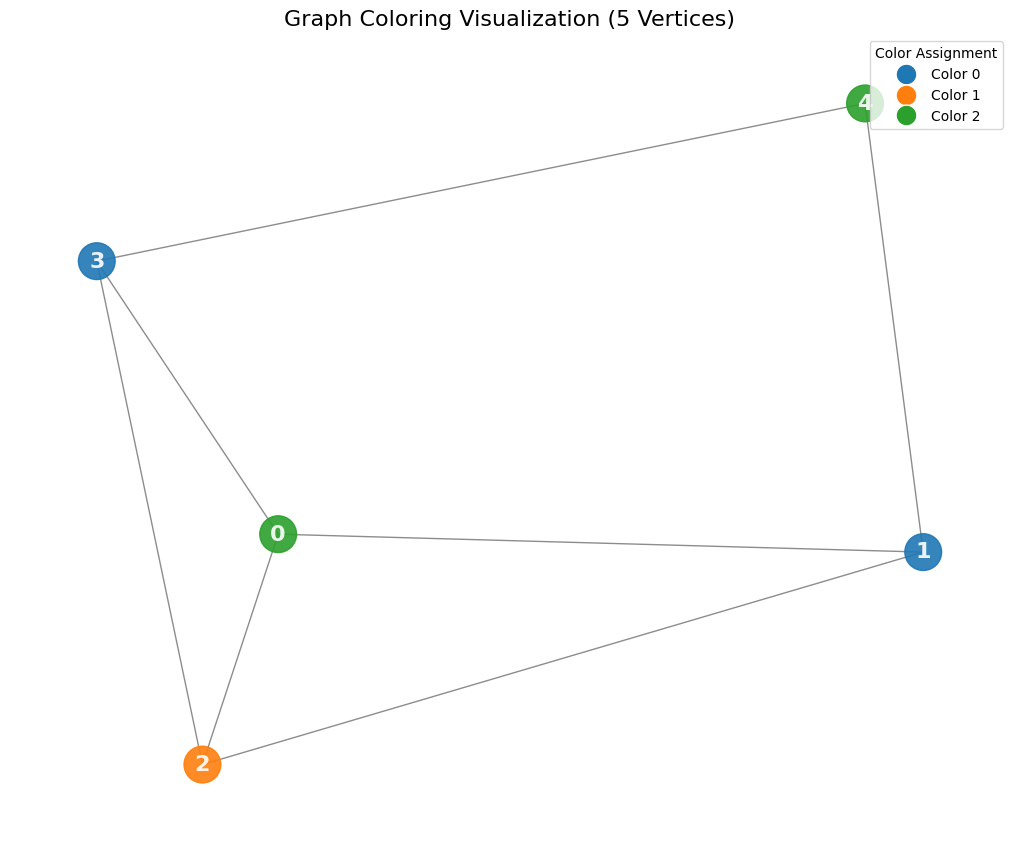

Solving the graph coloring problem with Google OR Tools...


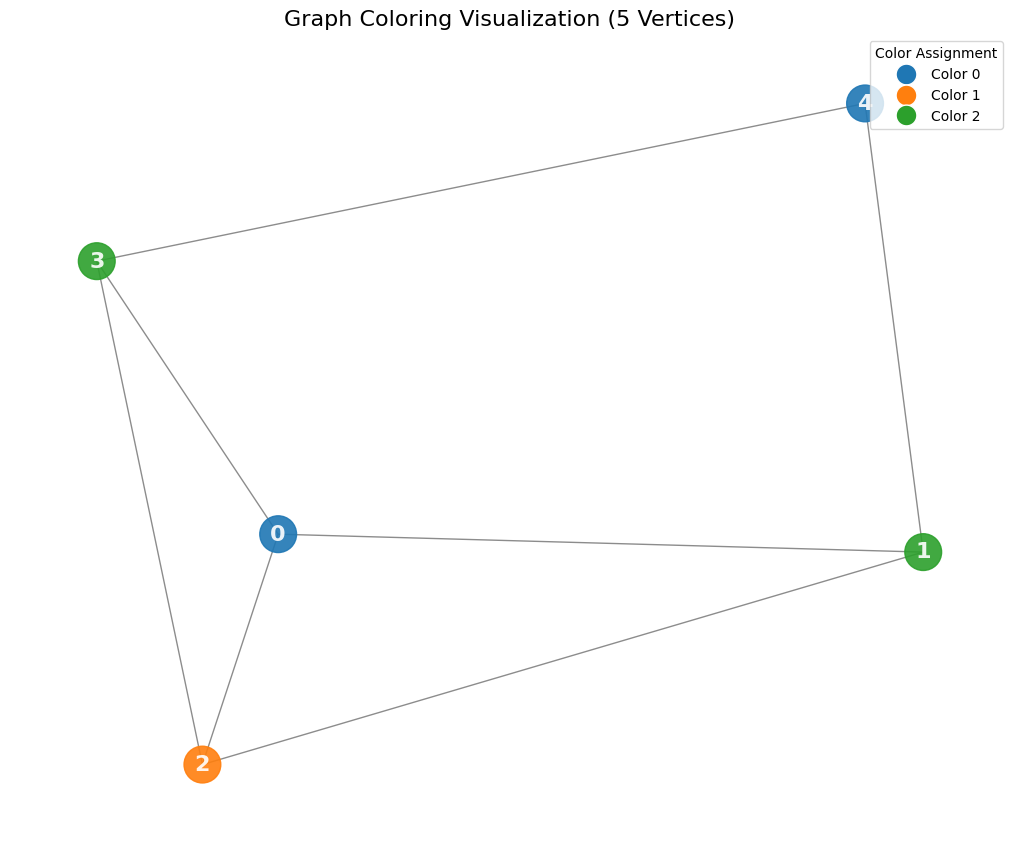

Solving the graph coloring problem with PuLP...


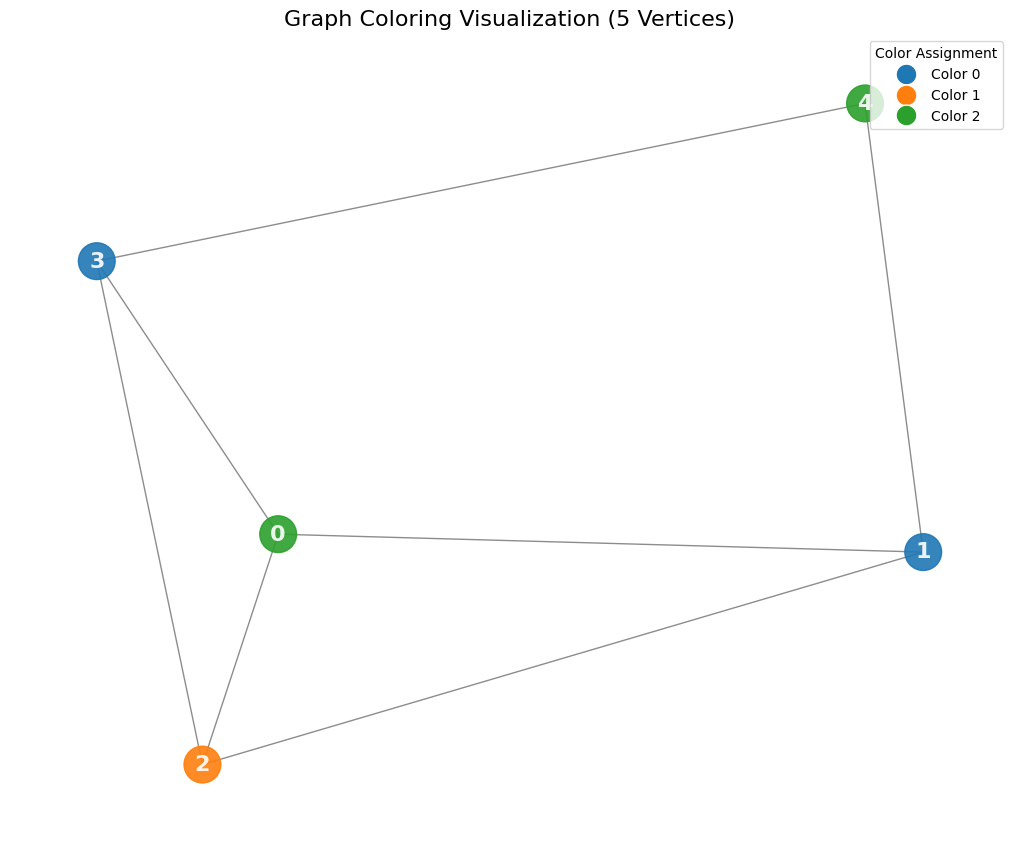

In [ ]:
if __name__ == "__main__":
    # Example graph with 5 vertices
    adjacency_matrix = [
        [0, 1, 1, 1, 0],  # Vertex 0 connected to 1, 2, 3
        [1, 0, 1, 0, 1],  # Vertex 1 connected to 0, 2, 4
        [1, 1, 0, 1, 0],  # Vertex 2 connected to 0, 1, 3
        [1, 0, 1, 0, 1],  # Vertex 3 connected to 0, 2, 4
        [0, 1, 0, 1, 0]   # Vertex 4 connected to 1, 3
    ]

    # Maximum number of colors we might need
    max_possible_colors = len(adjacency_matrix)

    # Step 1: Solve the problem
    print("Solving the graph coloring problem with Gurobi...")
    colors, num_colors = graph_coloring_gurobi(adjacency_matrix, max_possible_colors)
    if colors:
        # print(f"\nSolution found using {num_colors} colors:")
        # for i, color in enumerate(colors):
            # print(f"Vertex {i}: Color {color}")

        # Step 2: Visualize the solution
        # print("\nGenerating visualization...")
        plt = visualize_graph_coloring(adjacency_matrix, colors)

        # print("\nGraph structure:")
        # print("- The graph has 5 vertices (numbered 0-4)")
        # print("- Edges connect: (0,1), (0,2), (0,3), (1,2), (1,4), (2,3), (3,4)")

        # Display color mapping information
        # color_names = ["Blue", "Orange", "Green", "Red", "Purple"]
        # print("\nColor mapping:")
        # for color_value in sorted(set(colors)):
        #     vertices = [i for i, c in enumerate(colors) if c == color_value]
        #     print(f"- {color_names[color_value]} (Color {color_value}): Vertices {', '.join(map(str, vertices))}")

        # print("\nVerification:")
        # Verify the solution is valid
        # is_valid = True
        # for i in range(len(adjacency_matrix)):
        #     for j in range(i+1, len(adjacency_matrix)):
        #         if adjacency_matrix[i][j] == 1 and colors[i] == colors[j]:
        #             print(f"Invalid coloring: Vertices {i} and {j} are adjacent but have the same color {colors[i]}!")
        #             is_valid = False

        # if is_valid:
        #     print("The solution is valid - no adjacent vertices have the same color.")

        plt.show()
    else:
        print("No solution found")

    print("Solving the graph coloring problem with Google OR Tools...")
    colors, num_colors = graph_coloring_or_tools(adjacency_matrix, max_possible_colors)
    if colors:
        plt = visualize_graph_coloring(adjacency_matrix, colors)
        plt.show()
    else:
        print("No solution found")


    print("Solving the graph coloring problem with PuLP...")
    colors, num_colors = graph_coloring_pulp(adjacency_matrix, max_possible_colors)
    if colors:
        plt = visualize_graph_coloring(adjacency_matrix, colors)
        plt.show()
    else:
        print("No solution found")


## Comparison

Graph Coloring Solver Performance Comparison
Testing with 5 vertices...
Testing with 10 vertices...
Testing with 15 vertices...
Testing with 20 vertices...
Testing with 25 vertices...
Testing with 30 vertices...

Performance Summary:
---------------------------------------------
Vertices   OR-Tools     PuLP         Gurobi      
---------------------------------------------
5          0.0179s 0.0498s 0.0159s
10         0.0345s 0.4481s 0.0639s
15         0.0271s 1.0926s 0.1046s
20         0.0237s 1.1279s 0.0301s
25         0.0276s 2.6353s 0.3090s
30         0.0282s 10.4853s 0.1453s

Average Speedup Ratios:
PuLP is 95.10x slower than OR-Tools
PuLP is 23.11x slower than Gurobi
OR-Tools is 0.50x slower than Gurobi


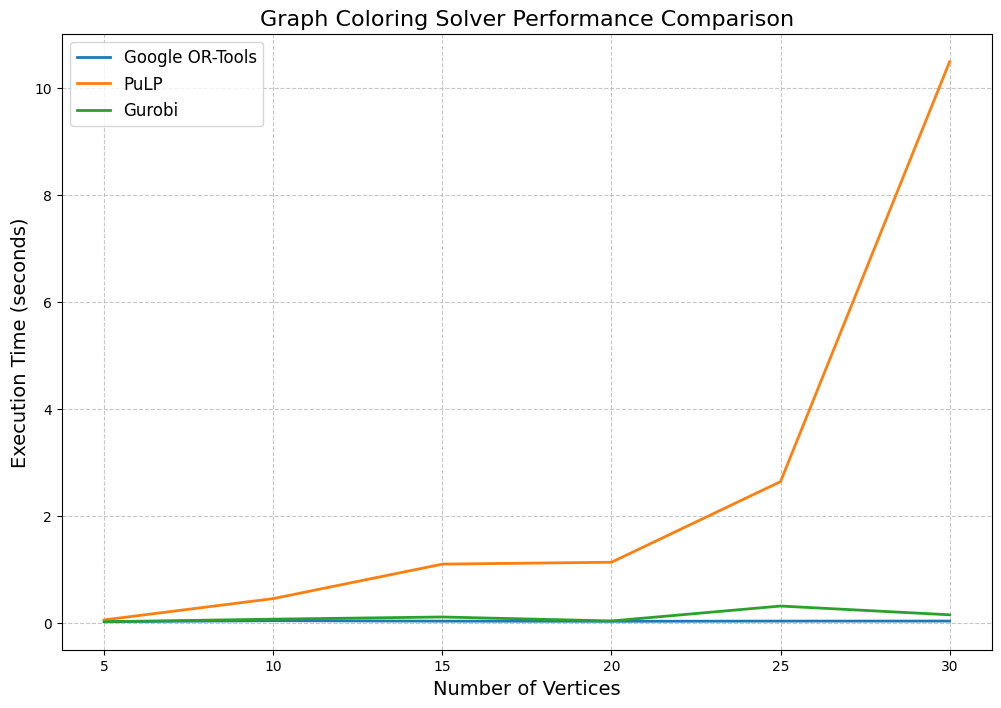

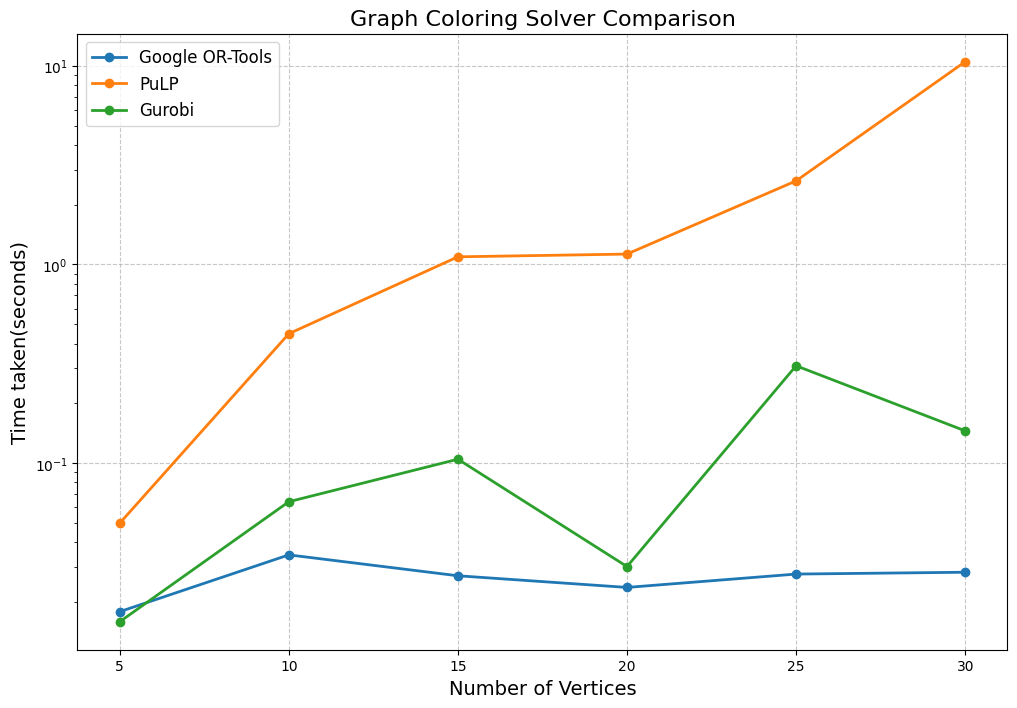

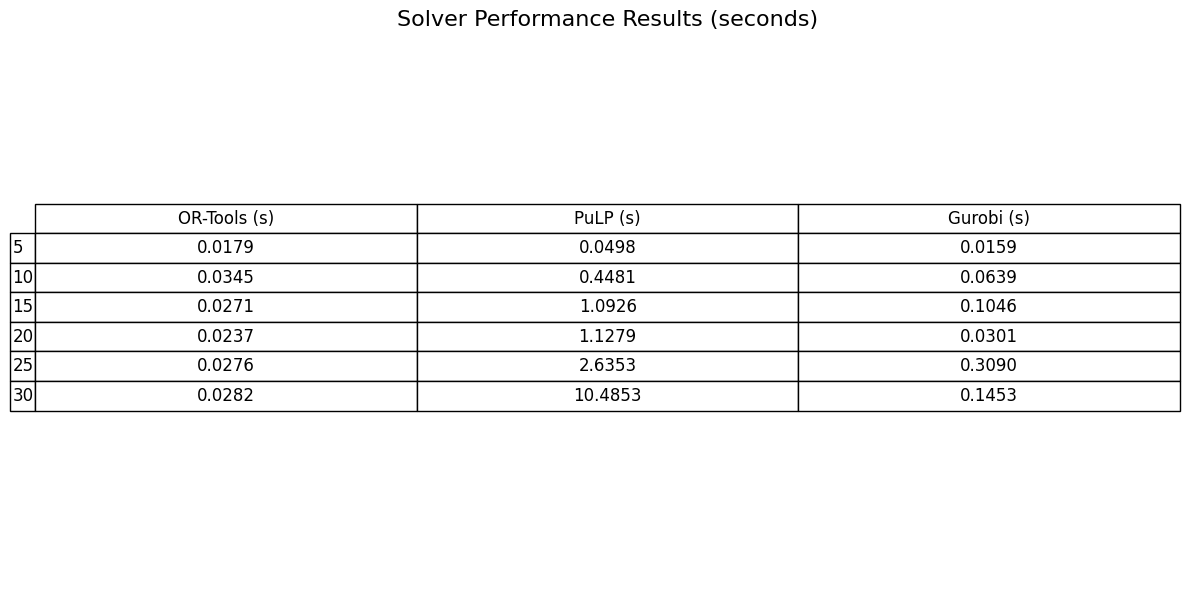

In [4]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from ortools.sat.python import cp_model
import pulp
try:
    import gurobipy as gp
    from gurobipy import GRB
    GUROBI_AVAILABLE = True
except ImportError:
    GUROBI_AVAILABLE = False
    print("Gurobi not available, skipping Gurobi tests")

def generate_random_graph(num_vertices, edge_probability=0.5):
    """Generate a random graph with the given number of vertices."""
    adjacency_matrix = [[0 for _ in range(num_vertices)] for _ in range(num_vertices)]

    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if random.random() < edge_probability:
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1

    return adjacency_matrix

def graph_coloring_or_tools(adjacency_matrix, max_colors):
    """Solve graph coloring using Google OR-Tools."""
    n = len(adjacency_matrix)

    # Create the model
    model = cp_model.CpModel()

    # Variables: color[i] is the color of vertex i (0 to max_colors-1)
    color = [model.NewIntVar(0, max_colors - 1, f'color_{i}') for i in range(n)]

    # Objective: minimize the maximum color used
    max_color_used = model.NewIntVar(0, max_colors - 1, 'max_color_used')
    model.AddMaxEquality(max_color_used, color)
    model.Minimize(max_color_used)

    # Constraints: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                model.Add(color[i] != color[j])

    # Symmetry breaking: color of first vertex = 0
    model.Add(color[0] == 0)

    # Solve the model
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 60  # 1 minute timeout
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extract solution
        vertex_colors = [solver.Value(color[i]) for i in range(n)]
        num_colors_used = max(vertex_colors) + 1
        return vertex_colors, num_colors_used
    else:
        return None, None

def graph_coloring_pulp(adjacency_matrix, max_colors):
    """Solve graph coloring using PuLP."""
    n = len(adjacency_matrix)

    # Create the model
    model = pulp.LpProblem("GraphColoring", pulp.LpMinimize)

    # Define the set of possible colors
    colors = range(max_colors)

    # Variables: x[i][j] = 1 if vertex i has color j, 0 otherwise
    x = {(i, j): pulp.LpVariable(f'x_{i}_{j}', cat=pulp.LpBinary)
         for i in range(n) for j in colors}

    # Variables: y[j] = 1 if color j is used, 0 otherwise
    y = {j: pulp.LpVariable(f'y_{j}', cat=pulp.LpBinary)
         for j in colors}

    # Objective: minimize the number of colors used
    model += pulp.lpSum(y[j] for j in colors)

    # Constraint: each vertex must have exactly one color
    for i in range(n):
        model += pulp.lpSum(x[i, j] for j in colors) == 1

    # Constraint: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                for c in colors:
                    model += x[i, c] + x[j, c] <= 1

    # Constraint: if color j is assigned to any vertex, then y[j] = 1
    for j in colors:
        for i in range(n):
            model += x[i, j] <= y[j]

    # Additional constraint: if color j is used, then color j-1 must be used (to avoid symmetry)
    for j in range(1, max_colors):
        model += y[j] <= y[j-1]

    # Solve the model with time limit
    solver = pulp.PULP_CBC_CMD(timeLimit=60, msg=False)  # 1 minute timeout
    model.solve(solver)

    if model.status == pulp.LpStatusOptimal:
        # Extract solution
        vertex_colors = [next(j for j in colors if pulp.value(x[i, j]) > 0.5) for i in range(n)]
        num_colors_used = sum(pulp.value(y[j]) > 0.5 for j in colors)
        return vertex_colors, int(num_colors_used)
    else:
        return None, None

def graph_coloring_gurobi(adjacency_matrix, max_colors):
    """Solve graph coloring using Gurobi."""
    if not GUROBI_AVAILABLE:
        return None, None

    n = len(adjacency_matrix)

    # Create a new model
    model = gp.Model("GraphColoring")

    # Suppress output
    model.setParam('OutputFlag', 0)
    model.setParam('TimeLimit', 60)  # 1 minute timeout

    # Define the set of possible colors
    colors = range(max_colors)

    # Variables: x[i,j] = 1 if vertex i has color j
    x = model.addVars([(i, j) for i in range(n) for j in colors], vtype=GRB.BINARY, name="x")

    # Variables: y[j] = 1 if color j is used
    y = model.addVars(colors, vtype=GRB.BINARY, name="y")

    # Objective: minimize the number of colors used
    model.setObjective(gp.quicksum(y[j] for j in colors), GRB.MINIMIZE)

    # Constraint: each vertex must have exactly one color
    for i in range(n):
        model.addConstr(gp.quicksum(x[i, j] for j in colors) == 1, f"OneColor_{i}")

    # Constraint: adjacent vertices must have different colors
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i][j] == 1:
                for c in colors:
                    model.addConstr(x[i, c] + x[j, c] <= 1, f"NoSameColor_{i}_{j}_{c}")

    # Constraint: if color j is assigned to any vertex, then y[j] = 1
    for j in colors:
        for i in range(n):
            model.addConstr(x[i, j] <= y[j], f"ColorUsed_{i}_{j}")

    # Additional constraint to break symmetry: if color j is used, then color j-1 must be used
    for j in range(1, max_colors):
        model.addConstr(y[j] <= y[j-1], f"Symmetry_{j}")

    # Solve the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Extract solution
        vertex_colors = [next(j for j in colors if x[i, j].X > 0.5) for i in range(n)]
        num_colors_used = sum(y[j].X > 0.5 for j in colors)
        return vertex_colors, int(num_colors_used)
    else:
        return None, None

def compare_solver_performance():
    """Compare solver performance as problem size increases."""
    # Problem sizes to test
    vertex_sizes = [5, 10,15,20,25,30]  # Adjust based on your machine's performance

    # Results storage
    ortools_times = []
    pulp_times = []
    gurobi_times = []

    # Run tests for each size
    for size in vertex_sizes:
        print(f"Testing with {size} vertices...")
        adj_matrix = generate_random_graph(size, edge_probability=0.3)
        max_colors = min(size, 10)  # Reasonable upper bound on colors

        # Test OR-Tools
        start_time = time.time()
        graph_coloring_or_tools(adj_matrix, max_colors)
        ortools_time = time.time() - start_time
        ortools_times.append(ortools_time)

        # Test PuLP
        start_time = time.time()
        graph_coloring_pulp(adj_matrix, max_colors)
        pulp_time = time.time() - start_time
        pulp_times.append(pulp_time)

        # Test Gurobi if available
        start_time = time.time()
        graph_coloring_gurobi(adj_matrix, max_colors)
        gurobi_time = time.time() - start_time
        gurobi_times.append(gurobi_time)

    return vertex_sizes, ortools_times, pulp_times, gurobi_times

def plot_performance_comparison(sizes, ortools_times, pulp_times, gurobi_times):
    """Plot solver performance comparison."""
    plt.figure(figsize=(12, 8))

    plt.plot(sizes, ortools_times, label='Google OR-Tools', linewidth=2, markersize=8)
    plt.plot(sizes, pulp_times, label='PuLP', linewidth=2, markersize=8)

    if GUROBI_AVAILABLE and gurobi_times:
        plt.plot(sizes, gurobi_times, label='Gurobi', linewidth=2, markersize=8)

    plt.xlabel('Number of Vertices', fontsize=14)
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.title('Graph Coloring Solver Performance Comparison', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # # Add data point annotations
    # for i, size in enumerate(sizes):
    #     plt.annotate(f"{ortools_times[i]:.2f}s",
    #                  (size, ortools_times[i]),
    #                  textcoords="offset points",
    #                  xytext=(0,10),
    #                  ha='center',
    #                  fontsize=9)

    #     plt.annotate(f"{pulp_times[i]:.2f}s",
    #                  (size, pulp_times[i]),
    #                  textcoords="offset points",
    #                  xytext=(0,10),
    #                  ha='center',
    #                  fontsize=9)

    #     if GUROBI_AVAILABLE and gurobi_times:
    #         plt.annotate(f"{gurobi_times[i]:.2f}s",
    #                      (size, gurobi_times[i]),
    #                      textcoords="offset points",
    #                      xytext=(0,10),
    #                      ha='center',
    #                      fontsize=9)

    # Add a logarithmic scale for better visibility of differences
    plt.figure(figsize=(12, 8))

    plt.semilogy(sizes, ortools_times, label='Google OR-Tools', linewidth=2, marker='o')
    plt.semilogy(sizes, pulp_times, label='PuLP', linewidth=2, marker='o')

    if GUROBI_AVAILABLE and gurobi_times:
        plt.semilogy(sizes, gurobi_times, label='Gurobi', linewidth=2, marker='o')

    plt.xlabel('Number of Vertices', fontsize=14)
    plt.ylabel('Time taken(seconds)', fontsize=14)
    plt.title('Graph Coloring Solver Comparison', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Create a table of results
    plt.figure(figsize=(12, 6))

    column_labels = ['Vertices', 'OR-Tools (s)', 'PuLP (s)']
    row_labels = [str(size) for size in sizes]

    table_data = []
    for i in range(len(sizes)):
        row = [ortools_times[i], pulp_times[i]]
        if GUROBI_AVAILABLE and gurobi_times:
            row.append(gurobi_times[i])
            if i == 0:  # Only add this for the first row
                column_labels.append('Gurobi (s)')

        table_data.append(row)

    # Format the data for the table
    cell_text = [[f"{value:.4f}" for value in row] for row in table_data]

    # Create the table
    the_table = plt.table(cellText=cell_text,
                          rowLabels=row_labels,
                          colLabels=column_labels[1:],  # Skip 'Vertices' as it's now row labels
                          loc='center',
                          cellLoc='center')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    the_table.scale(1, 1.5)

    plt.axis('off')
    plt.title('Solver Performance Results (seconds)', fontsize=16)

    # Adjust spacing between figures when showing
    plt.tight_layout()

    return plt

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)

    print("Graph Coloring Solver Performance Comparison")
    print("=" * 45)

    # Compare the solvers
    sizes, ortools_times, pulp_times, gurobi_times = compare_solver_performance()

    # Plot the results
    plt = plot_performance_comparison(sizes, ortools_times, pulp_times, gurobi_times)

    # Print summary
    print("\nPerformance Summary:")
    print("-" * 45)
    print(f"{'Vertices':<10} {'OR-Tools':<12} {'PuLP':<12} {'Gurobi':<12}")
    print("-" * 45)

    for i, size in enumerate(sizes):
        gurobi_str = f"{gurobi_times[i]:.4f}s" if GUROBI_AVAILABLE and i < len(gurobi_times) else "N/A"
        print(f"{size:<10} {ortools_times[i]:.4f}s {pulp_times[i]:.4f}s {gurobi_str}")

    # Calculate average speedups
    if GUROBI_AVAILABLE and gurobi_times:
        # Calculate speedup ratios
        pulp_to_ortools = [p/o for p, o in zip(pulp_times, ortools_times)]
        pulp_to_gurobi = [p/g for p, g in zip(pulp_times, gurobi_times)]
        ortools_to_gurobi = [o/g for o, g in zip(ortools_times, gurobi_times)]

        print("\nAverage Speedup Ratios:")
        print(f"PuLP is {sum(pulp_to_ortools)/len(pulp_to_ortools):.2f}x slower than OR-Tools")
        print(f"PuLP is {sum(pulp_to_gurobi)/len(pulp_to_gurobi):.2f}x slower than Gurobi")
        print(f"OR-Tools is {sum(ortools_to_gurobi)/len(ortools_to_gurobi):.2f}x slower than Gurobi")
    else:
        pulp_to_ortools = [p/o for p, o in zip(pulp_times, ortools_times)]
        print("\nAverage Speedup Ratios:")
        print(f"PuLP is {sum(pulp_to_ortools)/len(pulp_to_ortools):.2f}x slower than OR-Tools")

    plt.show()

Graph Coloring Solver Performance Comparison
Testing with 5 vertices...
Testing with 10 vertices...
Testing with 15 vertices...
Testing with 20 vertices...
Testing with 25 vertices...
Testing with 30 vertices...
Testing with 35 vertices...
Testing with 40 vertices...
Testing with 45 vertices...
Testing with 50 vertices...

Performance Summary:
---------------------------------------------
Vertices   OR-Tools     PuLP         Gurobi      
---------------------------------------------
5          0.0056s 0.0164s
10         0.0055s 0.0718s
15         0.0081s 0.3789s
20         0.0128s 1.1373s
25         0.0300s 2.7205s
30         0.0332s 10.8986s
35         0.0607s 4.5254s
40         0.0711s 12.0110s
45         31.1834s 55.2383s
50         1.7369s 55.9763s


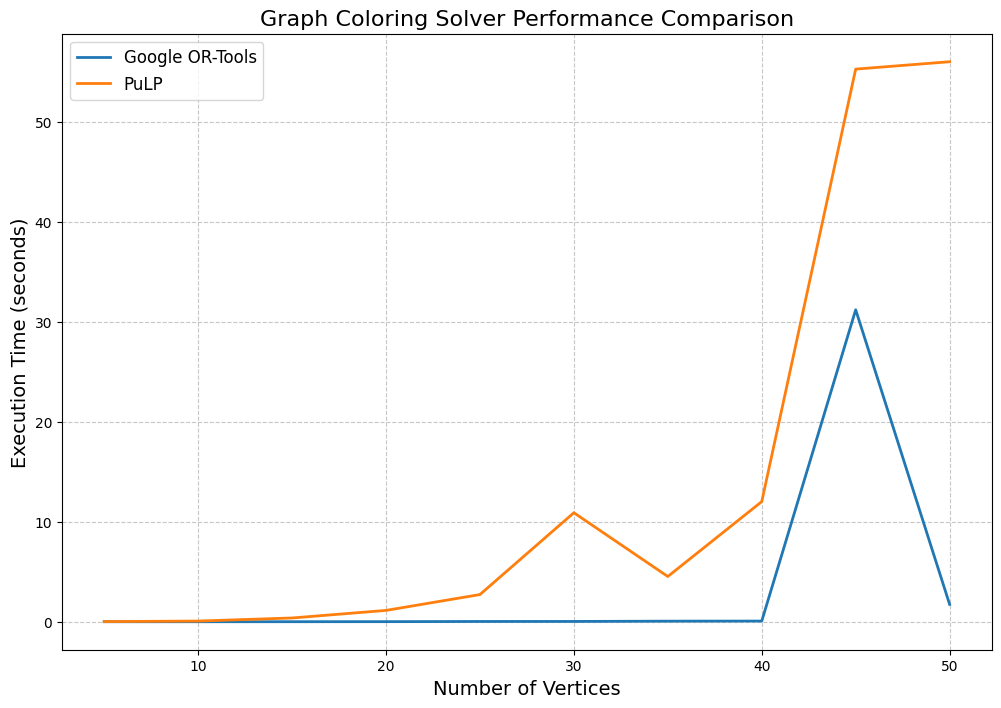

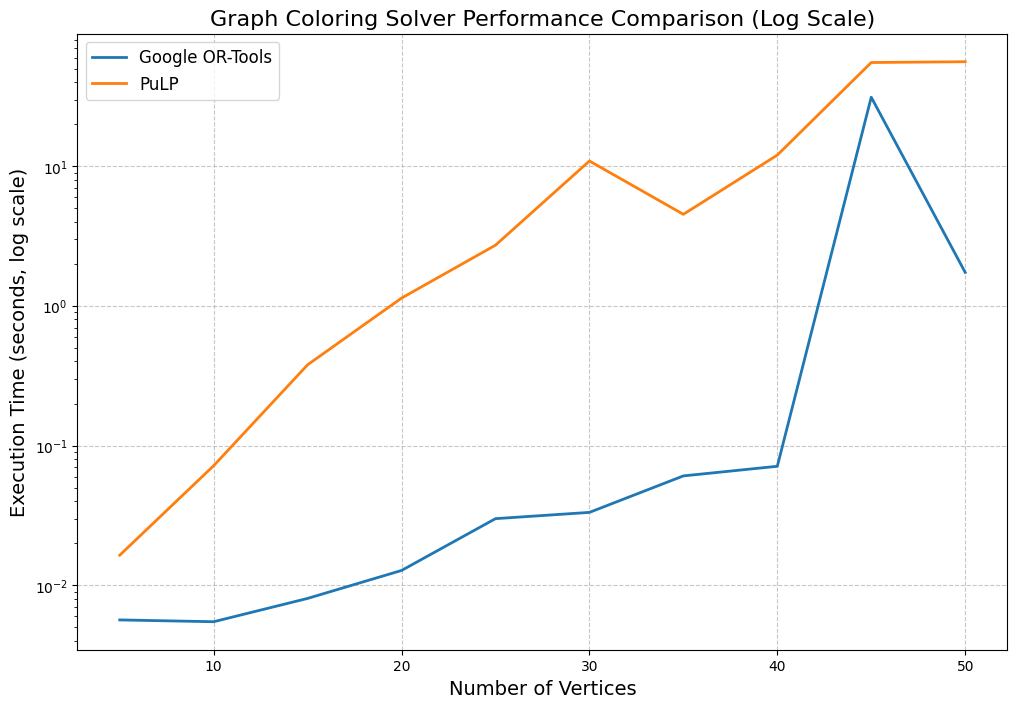

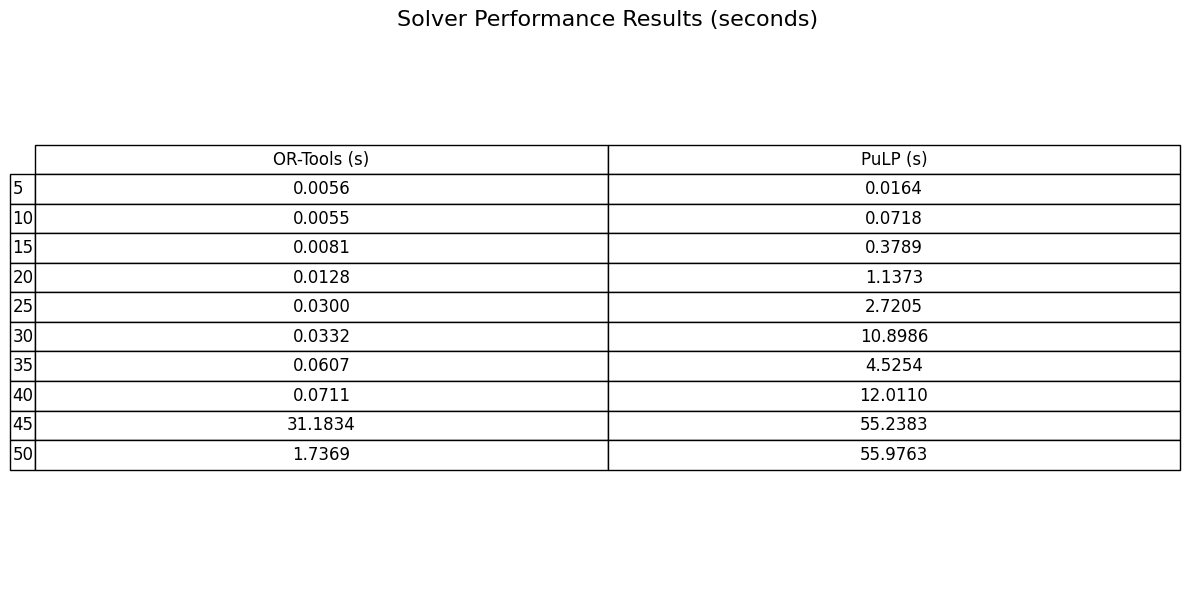

In [ ]:
def compare_solver_performance():
    """Compare solver performance as problem size increases."""
    # Problem sizes to test
    vertex_sizes = [5, 10,15,20,25,30,35,40,45,50]  # Adjust based on your machine's performance

    # Results storage
    ortools_times = []
    pulp_times = []
    # gurobi_times = []

    # Run tests for each size
    for size in vertex_sizes:
        print(f"Testing with {size} vertices...")
        adj_matrix = generate_random_graph(size, edge_probability=0.3)
        max_colors = min(size, 10)  # Reasonable upper bound on colors

        # Test OR-Tools
        start_time = time.time()
        graph_coloring_or_tools(adj_matrix, max_colors)
        ortools_time = time.time() - start_time
        ortools_times.append(ortools_time)

        # Test PuLP
        start_time = time.time()
        graph_coloring_pulp(adj_matrix, max_colors)
        pulp_time = time.time() - start_time
        pulp_times.append(pulp_time)


    return vertex_sizes, ortools_times, pulp_times

def plot_performance_comparison(sizes, ortools_times, pulp_times):
    """Plot solver performance comparison."""
    plt.figure(figsize=(12, 8))

    plt.plot(sizes, ortools_times, label='Google OR-Tools', linewidth=2, markersize=8)
    plt.plot(sizes, pulp_times, label='PuLP', linewidth=2, markersize=8)

    # if GUROBI_AVAILABLE and gurobi_times:
    #     plt.plot(sizes, gurobi_times, label='Gurobi', linewidth=2, markersize=8)

    plt.xlabel('Number of Vertices', fontsize=14)
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.title('Graph Coloring Solver Performance Comparison', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    plt.figure(figsize=(12, 8))

    plt.semilogy(sizes, ortools_times, label='Google OR-Tools', linewidth=2, markersize=8)
    plt.semilogy(sizes, pulp_times, label='PuLP', linewidth=2, markersize=8)

    # if GUROBI_AVAILABLE and gurobi_times:
    #     plt.semilogy(sizes, gurobi_times, label='Gurobi', linewidth=2, markersize=8)

    plt.xlabel('Number of Vertices', fontsize=14)
    plt.ylabel('Execution Time (seconds, log scale)', fontsize=14)
    plt.title('Graph Coloring Solver Performance Comparison (Log Scale)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Create a table of results
    plt.figure(figsize=(12, 6))

    column_labels = ['Vertices', 'OR-Tools (s)', 'PuLP (s)']
    row_labels = [str(size) for size in sizes]

    table_data = []
    for i in range(len(sizes)):
        row = [ortools_times[i], pulp_times[i]]
        table_data.append(row)

    # Format the data for the table
    cell_text = [[f"{value:.4f}" for value in row] for row in table_data]

    # Create the table
    the_table = plt.table(cellText=cell_text,
                          rowLabels=row_labels,
                          colLabels=column_labels[1:],  # Skip 'Vertices' as it's now row labels
                          loc='center',
                          cellLoc='center')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    the_table.scale(1, 1.5)

    plt.axis('off')
    plt.title('Solver Performance Results (seconds)', fontsize=16)

    # Adjust spacing between figures when showing
    plt.tight_layout()

    return plt

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)

    print("Graph Coloring Solver Performance Comparison")
    print("=" * 45)

    # Compare the solvers
    sizes, ortools_times, pulp_times = compare_solver_performance()

    # Plot the results
    plt = plot_performance_comparison(sizes, ortools_times, pulp_times)

    # Print summary
    print("\nPerformance Summary:")
    print("-" * 45)
    print(f"{'Vertices':<10} {'OR-Tools':<12} {'PuLP':<12} {'Gurobi':<12}")
    print("-" * 45)

    for i, size in enumerate(sizes):
        # gurobi_str = f"{gurobi_times[i]:.4f}s" if GUROBI_AVAILABLE and i < len(gurobi_times) else "N/A"
        print(f"{size:<10} {ortools_times[i]:.4f}s {pulp_times[i]:.4f}s")
    plt.show()